In [5]:
import os

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

from pathlib import Path

import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import torch
from dotenv import find_dotenv

from cvnets.yolo.v1.dataset import VOCDataset
from cvnets.yolo.v1.net import YOLOv1
from cvnets.yolo.v1.utils import decode_yolo_output, filter_detections
from cvnets.yolo.voc import VOCSplit

root = Path(find_dotenv(raise_error_if_not_found=True)).parent.absolute()
checkpoints = root.joinpath("src", "cvnets", "yolo", "v1", "checkpoints")

assert checkpoints.exists()

S = 7
B = 2
C = 20
imgsz = 448

In [6]:
dataset = VOCDataset("~/Documents/Datasets/VOC/", imgsz=imgsz, S=S, B=B, split=VOCSplit.TEST, normalize=False)
dataset.eval()

model = YOLOv1(imgsz=imgsz, S=S, B=B, C=C)
model.load_state_dict(torch.load(checkpoints.joinpath("yolov1-voc.pt"), map_location="cpu", weights_only=True))
model = model.eval()

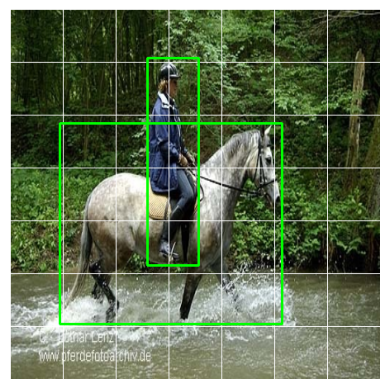

In [7]:
sample = dataset[12]

image = sample.image.permute(1, 2, 0).numpy().astype("uint8")
bboxes = sample.bboxes.numpy()
labels = sample.labels.numpy()

norm = A.Normalize()
image_tensor = norm(image=image)["image"]
image_tensor = torch.as_tensor(image_tensor).permute(2, 0, 1).unsqueeze(0).float()

with torch.inference_mode():
    prediction = model(image_tensor).reshape(1, S, S, 5 * B + C)

cell_size = imgsz // S
for i in range(S):
    for j in range(S):
        cv.rectangle(
            image, (j * cell_size, i * cell_size), ((j + 1) * cell_size, (i + 1) * cell_size), (255, 255, 255), 1
        )

for bbox in bboxes:
    cv.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)

plt.imshow(image)
plt.axis("off")
plt.show()

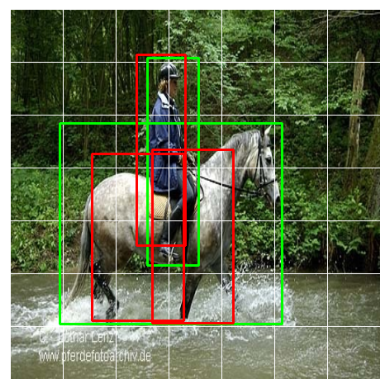

In [8]:
output = decode_yolo_output(prediction, imgsz, S, B)
xyxys, confs, labels = output[..., :4], output[..., 4], output[..., 5]
xyxys, confs, labels = xyxys.squeeze(), confs.squeeze(), labels.squeeze()
xyxys, confs, labels = filter_detections(xyxys, confs, labels)

img = image.copy()

for bbox in xyxys.numpy():
    cv.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 2)

plt.imshow(img)
plt.axis("off")
plt.show()